# EDA test for single game replays

In [1]:
import pickle
import pandas as pd
from math import pi 
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
import numpy as np


Metrics imported from pickled file

In [2]:
with open('max_metrics.pickle', 'rb') as picklefile:
    max_speed, max_boost_eff, max_agg, max_team_cohesion, max_game_inv = pickle.load(picklefile)

In [30]:
max_speed

46.27437424882789

In [3]:
df = pd.read_csv('../../1-data-collection/data/boay00.csv')

In [4]:
df = df

In [5]:
def make_spider(df, row, title, color):
    '''
    This function takes in a dataframe of player stats, and produces len(df) number of radar plots highlighting the playstyle of that player
    The y limit in floored a the minumum stat value - 1 and scaled according to the pro max metrics pickled above
    '''
    
    categories=list(df)[1:]
    N = len(categories)
    
    # set the angles of the plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(1,len(df),row+1, polar=True)

    # first axis on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # ylabels set ylim to lowest int(value) - 1
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5,6,7,8,9], ['1',"2",'3',"4",'5',"6",'7', "8",'9'], color="grey", size=7)
    lowest = df.select_dtypes(include = 'number').values.min()
    plt.ylim(min(5,max(0, (int(lowest) - 1))),10)

    values=df.loc[row].drop('player').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=11, color=color, y=1.1)

In [8]:
def make_plots(df_original, player_name):
    
    '''
    This function performs the full process of cleaning, metric calculation and plot generation following data collection.
    It generates the mean for each stat, splits these into required sub dataframes, then runs the stats through the algorithm created
    which then produces the general playstyle stats
    '''
    
    df = df_original.copy()
    
    # means calculation and cleaning
    means = df.mean(axis= 0)
    df.index = range(len(df.index))
    df = df.drop(columns = ['player_name'])
    df = df.append(means, ignore_index = True)
    df = df.loc[[len(df) - 1], :]
    df = df.rename(index={len(df): player_name})

    # some games save this stat, others do not, so just drop all instances
    try:
        df.drop(columns = 'goals_against_while_last_defender')
    except KeyError:
        pass

    to_drop = [
        'shots_against',
        'goals_against',
        'shooting_percentage',
        'bpm',
        'amount_stolen_big',
        'amount_stolen_small',
        'count_collected_big',
        'count_collected_small',
        'count_stolen_small',
        'count_stolen_big',
        'amount_overfill_stolen',
        'time_zero_boost',
        'time_full_boost',
        'time_boost_0_25',
        'time_boost_25_50',
        'time_boost_50_75',
        'time_boost_75_100',
        'avg_speed',
        'total_distance',
        'time_supersonic_speed',
        'time_boost_speed',
        'time_slow_speed',
        'time_ground',
        'time_low_air',
        'time_high_air',
        'time_powerslide',
        'time_defensive_third',
        'time_neutral_third',
        'time_offensive_third',
        'time_defensive_half',
        'time_offensive_half',
        'time_behind_ball',
        'time_infront_ball',
        'time_most_back',
        'time_most_forward',
        'time_closest_to_ball',
        'time_farthest_from_ball'
    ]
    df.drop(columns = to_drop, inplace = True)

    # assorting stats into their relevant metric categories
    speed = ['count_powerslide', 
             'percent_supersonic_speed', 
             'avg_speed_percentage', 
             'percent_slow_speed',
             'percent_high_air',
             'percent_low_air',
             'percent_ground',
             'bcpm'
            ]

    boost_efficiency = ['bcpm',
                        'avg_amount',
                        'amount_collected',
                        'amount_collected_big',
                        'amount_collected_small',
                        'amount_overfill',
                        'amount_used_while_supersonic',
                        'percent_zero_boost',
                        'percent_full_boost',
                        'percent_boost_0_25',
                        'percent_boost_25_50',
                        'percent_boost_50_75',
                        'percent_boost_75_100',
                        'avg_powerslide_duration',
                        'avg_speed_percentage',
                        'percent_boost_speed',
                        'percent_ground',
                        'percent_low_air',
                        'percent_high_air'
    ]

    aggression = ['amount_stolen',
                  'amount_used_while_supersonic',
                  'avg_distance_to_mates',
                  'inflicted',
                  'percent_defensive_third',
                  'percent_offensive_third',
                  'percent_infront_ball',
                  'percent_most_back',
                  'percent_most_forward'
    ]

    team_cohesion = ['goals',
                     'assists',
                     'amount_collected_big',
                     'amount_collected_small',
                     'avg_distance_to_ball_possession',
                     'avg_distance_to_ball_no_possession',
                     'avg_distance_to_mates'
    ]

    game_involvement = ['score',
                        'amount_collected',
                        'amount_stolen',
                        'percent_low_air',
                        'percent_ground',
                        'avg_distance_to_ball_possession',
                        'avg_distance_to_ball_no_possession',
                        'percent_closest_to_ball',
                        'percent_farthest_from_ball',
                        'inflicted'
    ]

    # create dataframes for each of the 5 metrics
    speed_df = df.loc[:, speed]
    boost_efficiency_df = df.loc[:, boost_efficiency]
    aggression_df = df.loc[:, aggression]
    team_cohesion_df = df.loc[:, team_cohesion]
    game_involvement_df = df.loc[:, game_involvement]



    # speed stat calculation
    # each addition was weighted to roughly the same weight using trial and error
    speed_df['speed'] = (speed_df.count_powerslide / 10
                        ) + (speed_df.avg_speed_percentage / 10
                        ) + (speed_df.percent_high_air
                        ) + ((speed_df.percent_low_air / speed_df.percent_ground) * 9
                        ) + (speed_df.bcpm / 66) + ((speed_df.percent_supersonic_speed/speed_df.percent_slow_speed
                        ) * 15)
    # speed stat scaled using pro max metric value
    speed_df['speed'] = speed_df['speed'] / max_speed * 9.5
    
    # process repeated for each of the 5 metrics
    boost_efficiency_df['boost_efficiency'] = boost_efficiency_df.avg_amount * (((boost_efficiency_df.amount_collected_small / boost_efficiency_df.amount_collected
                                              ) * 25) + ((1/boost_efficiency_df.avg_speed_percentage) * (boost_efficiency_df.bcpm) 
                                              ) * 1.2 + (1 / (boost_efficiency_df.amount_overfill / boost_efficiency_df.amount_collected)
                                              ) + (0.8 / (boost_efficiency_df.amount_used_while_supersonic / boost_efficiency_df.amount_collected)
                                              ) + (75 / boost_efficiency_df.percent_zero_boost
                                              ) + (1 - (abs(boost_efficiency_df.avg_powerslide_duration - 0.1
                                              )) * 100) + (((boost_efficiency_df.percent_boost_50_75
                                                    + boost_efficiency_df.percent_boost_75_100)
                                                   / (boost_efficiency_df.percent_boost_0_25
                                                    + boost_efficiency_df.percent_boost_25_50)
                                                  ) * 10)
    ) / 250





    boost_efficiency_df['boost_efficiency'] = (boost_efficiency_df.boost_efficiency / max_boost_eff
                                                                                        ) * 9.5
    aggression_df['aggression'] = (aggression_df.amount_stolen / 100
                                  ) + ((aggression_df.amount_used_while_supersonic / 100
                                  ) * 1.66) + (aggression_df.avg_distance_to_mates / 540
                                  ) + (aggression_df.inflicted * 6
                                  ) + ((aggression_df.percent_offensive_third/aggression_df.percent_defensive_third
                                  ) * 12) + ((aggression_df.percent_infront_ball / 10
                                  ) * 2.2) + ((aggression_df.percent_most_forward/aggression_df.percent_most_back
                                  ) * 6)


    aggression_df['aggression'] = (aggression_df.aggression / max_agg) * 9.5


    team_cohesion_df['team_cohesion'] = (((team_cohesion_df.amount_collected_small / team_cohesion_df.amount_collected_big
                                        ) * (boost_efficiency_df.amount_collected) 
                                        ) / 150) + (aggression_df.percent_most_back/team_cohesion_df.avg_distance_to_mates) * 800


    team_cohesion_df['team_cohesion'] = (team_cohesion_df.team_cohesion / max_team_cohesion) * 9.5

    game_involvement_df['game_involvement'] = (game_involvement_df.score / 60
                                                ) + ((game_involvement_df.amount_stolen / game_involvement_df.amount_collected
                                                ) * 25
                                                ) + ((100 - game_involvement_df.percent_ground
                                                ) / 7
                                                ) + (game_involvement_df.percent_closest_to_ball / 5
                                                # ) + ((game_involvement_df.inflicted
                                                # ) * 7
                                                    ) + (game_involvement_df.score / 70)


    game_involvement_df['game_involvement'] = (game_involvement_df.game_involvement / max_game_inv) * 9.5
    ## radar plot code taken from github example and adapted for personal needs

    # new dataframe created for the metrics
    # Set data
    df_2 = pd.DataFrame({
    'player' : [player_name],
    """Speed""": min(10,speed_df.loc[player_name, 'speed']
    ),
    """  Boost 
            Efficiency""":     min(10,min(speed_df.loc[player_name, 'speed'] * 2, boost_efficiency_df.loc[player_name, 'boost_efficiency'])
                                  
    ),
    """  Aggression""": min(10,aggression_df.loc[player_name, 'aggression']

    ),
    """Team Cohesion       """: min(10, min(speed_df.loc[player_name, 'speed'] * 2, team_cohesion_df.loc[player_name, 'team_cohesion']
    ))
    ,
    """   Game    
    Involvement               """: min(10,game_involvement_df.loc[player_name, 'game_involvement']

    )
    })


    my_dpi=96
    plt.figure(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)

    # color palette
    my_palette = plt.cm.get_cmap('Set2', len(df_2.index))

    # loop to plot
    for row in range(0, len(df_2.index)):
        make_spider(df = df_2, row=row, title=df_2['player'][row], color=my_palette(row))
    return plt, df_2


/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_5007/2443673295.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean(axis= 0)
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_5007/2443673295.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(means, ignore_index = True)
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_5007/2443673295.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap('Set2', len(df_2.index))


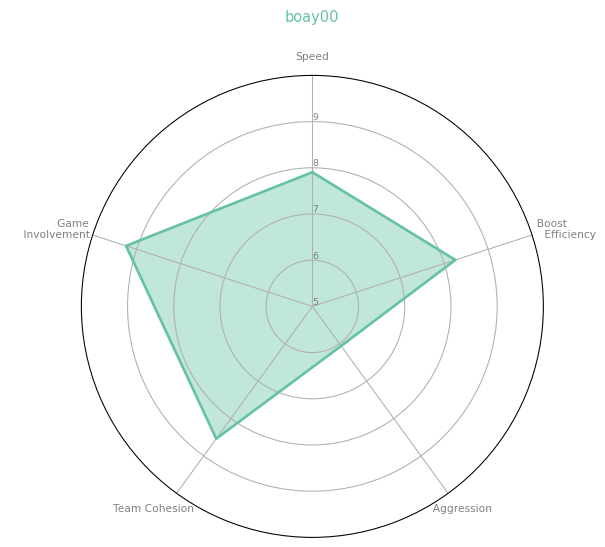

In [9]:
plot, df_2 = make_plots(df.head(1), 'boay00')

In [36]:
df_2

,group,speed,boost \n efficiency,aggression,team cohesion,game \n involvement
0,boay00,6.835501,6.741811,5.099695,7.188493,7.778202


In [37]:
df_2_n = df_2.select_dtypes(include = 'number').values.min()
df_2_n
# df_2_n.values.min()

5.099694599445191

In [38]:
(boost_efficiency_df.boost_efficiency / 9.117117480246007
                                                                                        ) * 9.5

NameError: name 'boost_efficiency_df' is not defined